# ADHunter mutagenesis


In [1]:
import torch
# from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
import os
os.chdir("../adhunter")
import sys
sys.path.append("../src/")
import src

alphabet = src.get_alphabet()
aa_to_i, i_to_aa = src.get_encoding()

# load in AD data
fn = "../data/OrthologTilingDFwActivities_20240930_train_test_val.csv"
df = pd.read_csv(fn)
thresh = 80_000

# Load in model
model = src.load_model("adhunter_1he_syn.pt")
model.eval()


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ActCNNSystem(
  (model): ActCNN(
    (emb): Linear(in_features=20, out_features=64, bias=False)
    (conv_init): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (res_blocks): ModuleList(
      (0-2): 3 x ResBlock(
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_res): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(3,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_block): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (pool): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
    (lin): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
  (rmse): MeanSquaredError()
  (pearsonr): PearsonCorrCoef()
  (spearmanr): SpearmanCorrCoef()
)

In [2]:
import copy
# np.random.seed(99)

def mut_step(seq):
    """For a given sequence, randomly replace an AA at each 
    position with another AA, then run ADHunter on all of 
    those sequences + the original and select the one with 
    the highest score

    Args:
        seq (torch.tensor): Starting sequence. Must be a 
        tensor of integers corresponding to AAs

    Returns:
        best_seq: highest scoring sequence
        best_score: highest score
    """    
    rand_seqs = [seq]
    for i in range(len(seq)):
        seq_i = copy.deepcopy(seq)
        seq_i[i] = np.random.randint(0, 20)
        rand_seqs.append(seq_i)

    rand_seqs = torch.tensor(np.vstack(rand_seqs))
    with torch.no_grad():
        rand_scores = model(rand_seqs)

    idxmax = torch.argmax(rand_scores)
    best_seq, best_score = rand_seqs[idxmax], rand_scores[idxmax]
    return best_seq, best_score


def run_mutagenesis(seq0 = None, n_iters=100):
    if type(seq0) == str:
        alphabet="ACDEFGHIKLMNPQRSTVWY"
        aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
        seq0 = torch.tensor([aa_to_i[i] for i in seq0])
    if seq0 is None:
        seq0 = torch.tensor(np.random.randint(0, 20, 40))
    with torch.no_grad():
        seqs, scores = [seq0], [model(seq0.unsqueeze(0))]
    seqs, scores
    for i in range(n_iters):
        seq_i, score_i = mut_step(seqs[-1])
        seqs.append(seq_i)
        scores.append(score_i)
    seqs = torch.vstack(seqs)
    scores = torch.concat(scores)
    return seqs, scores

In [3]:
mp = "adhunter_1he.pth"
mp.split("/")[-1].split(".pt")[0]
2**40

1099511627776

In [4]:
def legend_kwargs():
    # Commonly used kwargs for figure legends
    kwargs = {
        "frameon" : False, 
        "bbox_to_anchor" : (1, 0.5), 
        "loc" : "center left"}
    return kwargs

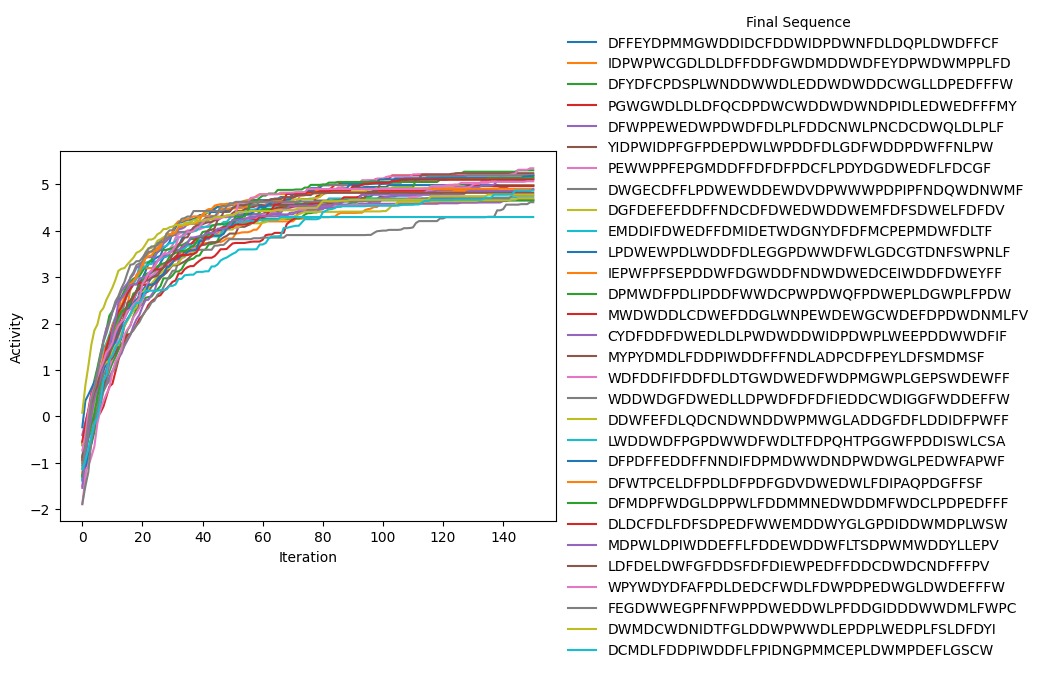

In [5]:
translator = lambda seq: "".join([i_to_aa[i] for i in seq.numpy()])


np.random.seed(42)
seqs_initial, scores, seqs_final = [], [], []
for _ in range(30):
    seed_seq = torch.tensor(np.random.randint(0, 20, 40))
    seqs_i, scores_i = run_mutagenesis(seed_seq, 150)
    seq_final = translator(seqs_i[-1])
    plt.plot(range(len(scores_i)), scores_i, label=seq_final)
    # Store stuff
    seqs_initial.append(translator(seed_seq))
    seqs_final.append(seq_final)
    scores.append(scores_i[-1].item())
plt.legend(title="Final Sequence", **legend_kwargs())
plt.ylabel("Activity")
plt.xlabel("Iteration")
plt.show()

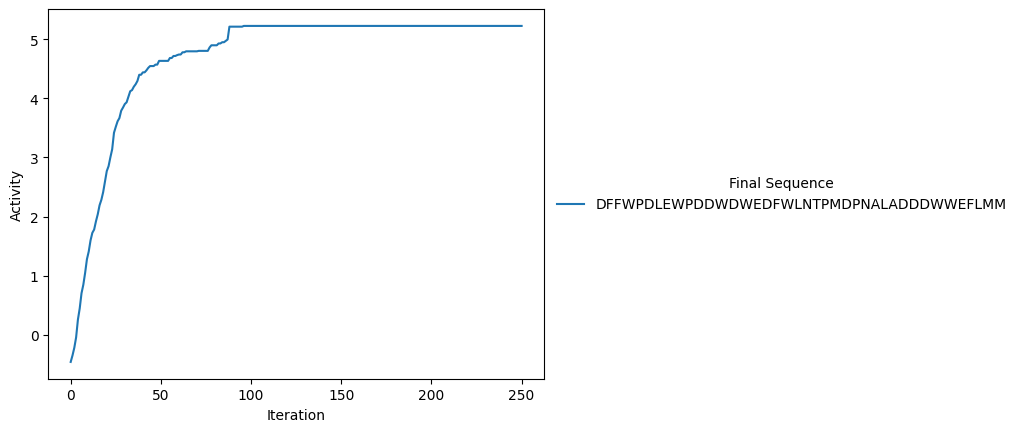

In [6]:
for _ in range(1):
    seed_seq = torch.tensor(np.random.randint(0, 20, 40))
    seqs_i, scores_i = run_mutagenesis(seed_seq, 250)
    seq_final = translator(seqs_i[-1])
    plt.plot(range(len(scores_i)), scores_i, label=seq_final)
    # # Store stuff
    # seqs_initial.append(translator(seed_seq))
    # seqs_final.append(seq_final)
    # scores.append(scores_i[-1].item())
plt.legend(title="Final Sequence", **legend_kwargs())
plt.ylabel("Activity")
plt.xlabel("Iteration")
plt.show()

In [7]:
result_df = pd.DataFrame(np.vstack([seqs_initial, seqs_final, scores]).T)
result_df.columns = ["initial_seq", "final_seq", "activity"]
result_df

,initial_seq,final_seq,activity
0,HYRMIHWMMEIDCNGCANNTLSRRWNYDFWHKHVEQVKCY,DFFEYDPMMGWDDIDCFDDWIDPDWNFDLDQPLDWDFFCF,4.980856895446777
1,KPRRFWYQTVDCALWTNANTDMTDIYEHQQESATLSSIHG,IDPWPWCGDLDLDFFDDFGWDMDDWDFEYDPWDWMPPLFD,4.661198616027832
2,DEGNWLATSKKKNKRCMMIGYHDIVTMCWHVIQHETFNKY,DFYDFCPDSPLWNDDWWDLEDDWDWDDCWGLLDPEDFFFW,5.299097537994385
3,IDEACPKNLLVNSGLRKCVNDHKIGAQSSEGRIAPVVPQM,PGWGWDLDLDFQCDPDWCWDDWDWNDPIDLEDWEDFFFMY,5.1887006759643555
4,IAHCHHKEHYVPMKQIQTQFLGLMGLQYDHCHTPKPRPTI,DFWPPEWEDWPDWDFDLPLFDDCNWLPNCDCDWQLDLPLF,4.652677536010742
5,ATDVVCEALFFKQPPATYIDTNVQMSEVHMSSDKIHTMEE,YIDPWIDPFGFPDEPDWLWPDDFDLGDFWDDPDWFFNLPW,4.968601226806641
6,MEMKGTKGGEYMDVSSNQKHQYYLMHWWMGIAIFLCECRY,PEWWPPFEPGMDDFFDFDFPDCFLPDYDGDWEDFLFDCGF,5.2154717445373535
7,SYLLYSYAMPVFEGRCEQEVYSKIMQTPIQMKIQRANFQS,DWGECDFFLPDWEWDDEWDVDPWWWPDPIPFNDQWDNWMF,4.612058639526367
8,QDFGMWCNQKYSTTCLMDCEIWYVACILWHTDRETMGTLA,DGFDEFEFDDFFNDCDFDWEDWDDWEMFDFSDWELFDFDV,4.970470428466797
9,CVDCAFHYEDGNSIMPQVIAETYGFQWQCKHVYMILVTTA,EMDDIFDWEDFFDMIDETWDGNYDFDFMCPEPMDWFDLTF,4.713532447814941


### Do mutagenesis starting with top activators in synthetics

In [8]:
torch.tensor(np.random.randint(0, 20, (30, 40)))

tensor([[ 7,  5, 19,  ...,  2, 13,  5],
        [16, 18, 11,  ..., 10,  3, 17],
        [19,  0, 19,  ...,  5, 17, 10],
        ...,
        [ 5,  1, 17,  ...,  5,  3,  4],
        [10, 17, 10,  ...,  5, 16,  9],
        [18, 10,  5,  ...,  5,  2,  6]])

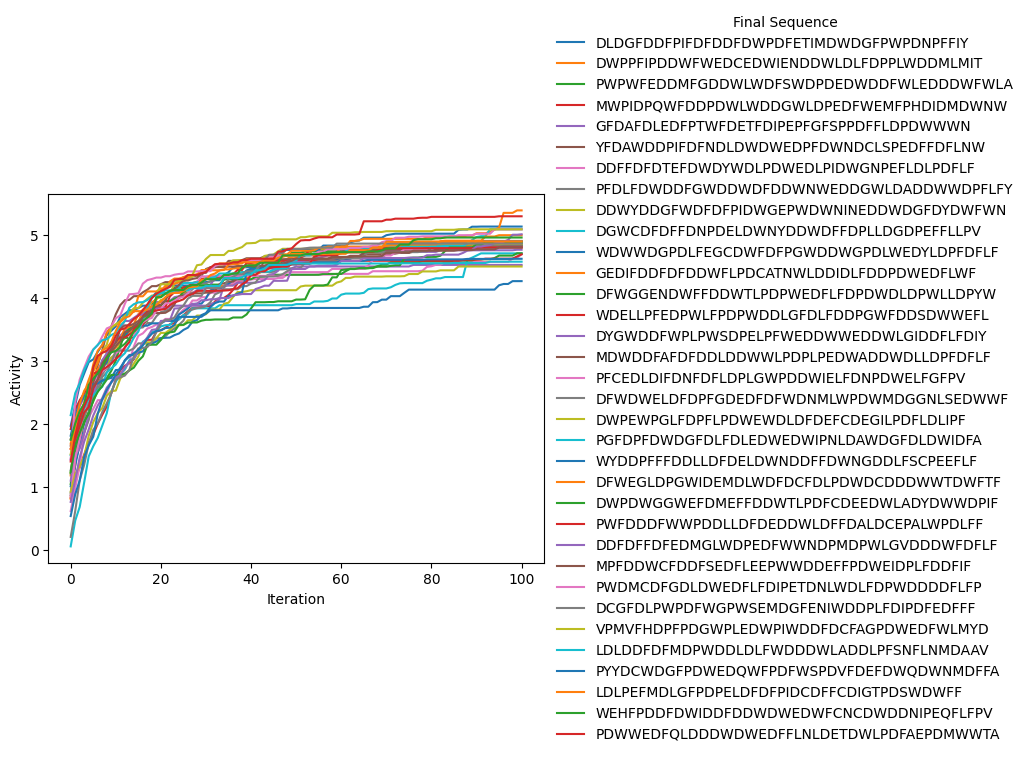

In [9]:
sdf = pd.read_csv("../data/SynAD_Glu_Filtered_ActivityCtrlStd_replicateactivities.csv")
sdf.sort_values(by="Activity", ascending=False, inplace=True)
amax = sdf["Activity"].max()
strong_synthetics = (torch.tensor(
    np.vstack(
        sdf.loc[sdf["Activity"] == amax, "AAseq"]
        .apply(lambda seq: np.array([aa_to_i[i] for i in seq]))
        .values)))


np.random.seed(42)
syn_seqs_initial, syn_scores, syn_seqs_final = [], [], []
for seed_seq in strong_synthetics:
    seqs_i, syn_scores_i = run_mutagenesis(seed_seq, 100)
    seq_final = translator(seqs_i[-1])
    plt.plot(range(len(syn_scores_i)), syn_scores_i, label=seq_final)
    # Store stuff
    syn_seqs_initial.append(translator(seed_seq))
    syn_seqs_final.append(seq_final)
    syn_scores.append(syn_scores_i[-1].item())
plt.legend(title="Final Sequence", **legend_kwargs())
plt.ylabel("Activity")
plt.xlabel("Iteration")
plt.show()

In [10]:
syn_act = model(strong_synthetics).detach().squeeze()
syn_result_df = pd.DataFrame(np.vstack([syn_seqs_initial, syn_act, syn_seqs_final, syn_scores]).T)
syn_result_df.columns = ["initial_seq", "initial_activity","final_seq", "activity"]
syn_result_df

,initial_seq,initial_activity,final_seq,activity
0,SFLALPDLEIYNFEPWDLPDFTTVGDFDGFSISDLRFLID,1.9770567,DLDGFDDFPIFDFDDFDWPDFETIMDWDGFPWPDNPFFIY,4.876119136810303
1,SLPPLILPDMALENYEELSEIDQWLYLFDPFSWSELLKNI,1.1901497,DWPPFIPDDWFWEDCEDWIENDDWLDLFDPPLWDDMLMIT,4.829187393188477
2,MYPSIEDDDDVDDLLVDFSNDDDENIFPFFEEGDIRLWNF,1.053916,PWPWFEDDMFGDDWLWDFSWDPDEDWDDFWLEDDDWFWLA,4.850170135498047
3,SASILNDVGVDDDDLNMDQDYDFSQFLEEFAPLLKLDAAC,0.8352355,MWPIDPQWFDDPDWLWDDGWLDPEDFWEMFPHDIDMDWNW,4.908271312713623
4,EFDDFNFEDYLTFFDETFDINELLGISSSNFVLDPSYSDQ,1.4458916,GFDAFDLEDFPTWFDETFDIPEPFGFSPPDFFLDPDWWWN,4.530725955963135
5,VNDAMVSLMFDVNDLDFLWESPIDESDPLVKEDLPDLFDY,0.87695235,YFDAWDDPIFDFNDLDWDWEDPFDWNDCLSPEDFFDFLNW,4.810544490814209
6,QEVFNFNGELEIENWELPSLEEENVDFLFHSFLELTQFPS,0.6252918,DDFFDFDTEFDWDYWDLPDWEDLPIDWGNPEFLDLPDFLF,4.700753211975098
7,SGVTYNVGVEEDDDYLFDPKFAEKVPVLDPDSFVNEFLQV,0.91453516,PFDLFDWDDFGWDDWDFDDWNWEDDGWLDADDWWDPFLFY,4.9113969802856445
8,LLWGNDGDYDLSASLDIDEPHECFIDEDDILGFDYHVLIP,1.2365017,DDWYDDGFWDFDFPIDWGEPWDWNINEDDWDGFDYDWFWN,4.851990699768066
9,MGAIDFDSWDAASRKDLIPEDSDILYKLHGSLGEELELGF,0.06426559,DGWCDFDFFDNPDELDWNYDDWDFFDPLLDGDPEFFLLPV,4.713925838470459


## Using DeepLIFT to sample other guys

In [11]:
from captum.attr import LayerDeepLift
baseline_null = torch.zeros(1, 40, 20)
dl = LayerDeepLift(model, model.model.emb, multiply_by_inputs=True)
# Try it out
X_sample = model.model.encode(syn_result_df["final_seq"][0])
with torch.no_grad():
    a = dl.attribute(X_sample, baseline_null, attribute_to_layer_input=True).squeeze()
    adf = pd.DataFrame(a).T
    adf.index = list(src.get_alphabet())
    neg_pos = torch.where(a < 0)[0]
    display(adf)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
A,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
D,0.001827,0.000000,0.033929,0.000000,0.000000,0.138425,0.068703,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,0.064316,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
F,0.000000,0.000000,0.000000,0.000000,-0.000169,0.000000,-0.000000,0.044313,-0.000000,-0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.535196,0.386428,0.000000,0.000000
G,0.000000,-0.000000,-0.000000,0.025959,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
H,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
I,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.015605,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127204,0.000000
K,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
L,0.000000,0.065272,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


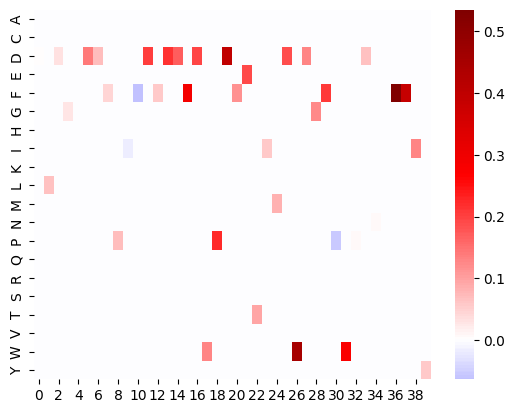

In [12]:
sns.heatmap(adf, cmap="seismic", center=0)
plt.show()
neg_pos = torch.where(a < 0)[0]

In [14]:
from itertools import product

max_edit = 3
n_edit = min(max_edit, len(neg_pos))
edit_pos = np.random.choice(neg_pos, n_edit, replace=False)
candidates = []
# Generate all combos of AAs across positions to edit and create 
# sequences with those changes
aa_combos = list(product(*[range(20) for _ in range(n_edit)]))
for combo in aa_combos:
    x = copy.deepcopy(X_sample).squeeze()
    x[edit_pos] = torch.zeros_like(x[edit_pos])
    x[edit_pos, combo] = 1
    candidates.append(x)

candidates = torch.stack(candidates)
candidate_preds = model(candidates)
candidate_preds.max(), model(X_sample)

(tensor(4.9119, grad_fn=<MaxBackward1>),
 tensor([4.8761], grad_fn=<ViewBackward0>))

In [15]:
translator(candidates[0].argmax(dim=1))

def onehot_translator(seq):
    return translator(seq.argmax(dim=-1).squeeze())
# translator(candidates[candidate_preds.argmax()].argmax(dim=1))
print(onehot_translator(X_sample))
X_best = candidates[candidate_preds.argmax()]
print(onehot_translator(X_best))
# translator(X_sample.argmax(dim=-1).squeeze())

DLDGFDDFPIFDFDDFDWPDFETIMDWDGFPWPDNPFFIY
DLDGFDDFPILDFDDFDWPDFETIMDWDGFPWPDNPFFIY


## Synthetics WLF motifs

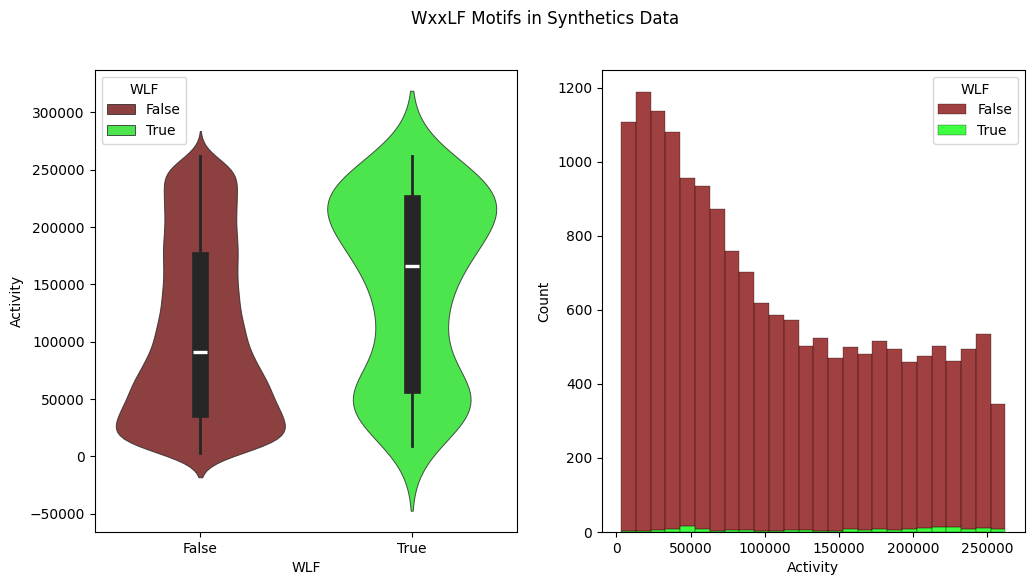

163
17107


TtestResult(statistic=np.float64(6.813358636769325), pvalue=np.float64(1.7032926636434064e-10), df=np.float64(164.87937931043933))

In [74]:
from scipy.stats import ttest_ind

sdf["WLF"] = False
sdf.loc[sdf["AAseq"].str.contains("W..LF"), "WLF"] = True

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(sdf, x="WLF", y="Activity", hue="WLF", 
               palette=["maroon", "lime"], ax=axs[0], alpha=.8, linewidth=.7,
                inner_kws=dict(box_width=12, whis_width=2,)
               )

sns.histplot(sdf, x="Activity", hue="WLF", multiple="stack", 
             palette=["maroon", "lime"], ax=axs[1],
             linewidth=0.2)
plt.suptitle("WxxLF Motifs in Synthetics Data")
plt.show()


a_wlf = sdf.loc[sdf["WLF"]==True, "Activity"].values
a_other = sdf.loc[sdf["WLF"]==False, "Activity"].values
print(len(a_wlf))
print(len(a_other))

ttest_ind(a_wlf, a_other, equal_var=False)

## Why do these sequences get so many tryptophans?
DeepLIFT indicated that F was the most important residue, so I think it's odd that W's, not F's, are the main aromatic in these mutagenized sequences. 

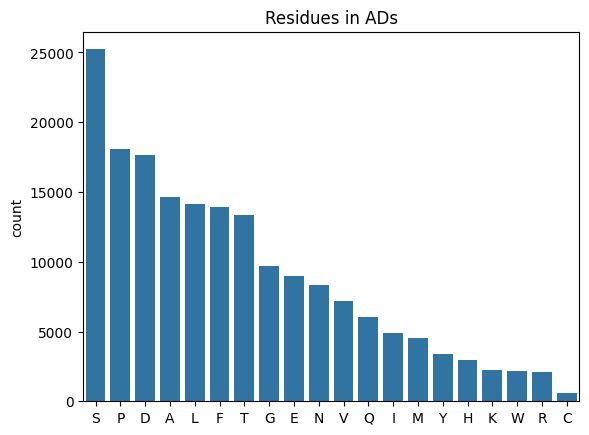

In [16]:
fn = "../data/OrthologTilingDFwActivities_20240930.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()


df = pd.read_csv(fn)
df["Activity"] = df["Activity"].fillna(0.0)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# 
df = df.dropna(subset=df.columns[:-1], axis=0)
thresh = 80_000
ad_res_cts = pd.Series(list(df.loc[df["Activity"] >= thresh, "Seq"].sum())).value_counts()
sns.barplot(ad_res_cts)
plt.title("Residues in ADs")
plt.show()

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_25839/3198476319.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x="W", y="Activity",
/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_25839/3198476319.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.boxplot(df, x="W", y="Activity",


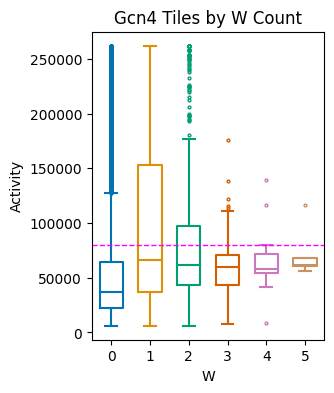

In [17]:
df["W"] = df["Seq"].str.count("W")
df_ad = df[df["Activity"] >= thresh]
# sns.boxplot(df_ad, x="W", y="Activity")
# sns.violinplot(df, x="W", y="Activity", palette=sns.color_palette("colorblind"))
plt.figure(figsize=(3,4))
sns.boxplot(df, x="W", y="Activity", 
            palette=sns.color_palette("colorblind"), width=.6, 
            fliersize=2, 
            fill=None)
# sns.stripplot(df, x="W", y="Activity")
plt.axhline(thresh, c='magenta', linewidth=1, linestyle="--")
plt.title("Gcn4 Tiles by W Count")
plt.show()